## Sentiment Analysis with Tweepy

### Set up environment

In [ ]:
#tweepy is a open source Python package that gives you a very convenient way to access the Twitter API with Python
#installing tweepy
!pip install tweepy==4.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 KB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 2.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: tweepy
    Found existing installation: tweepy 3.10.0
    Uninstalling tweepy-3.10.0:
      Successfully uninstalled tweepy-3.10.0


 

1.   Textblot and Vader is used for sentiment analysis in social media
2.   From textblot, we call sentiment methods, that will give polarity value and subjectivity value. Polarity means how postive or negative is the sentiments. Its value ranges from -1 to +1, where as subjectivity value ranges from 0-1, where 1 means persional opinions (sujbective information)and 0 means factual information.
3. vader gives four values-pos, neg, nut and compound where compound is the normalize value of all the rating and lies in range -1 to 1.




In [ ]:
import tweepy
import pandas as pd
import re #This module provides regular expression matching operations
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')

import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


### Twitter Authentication

In [ ]:
#Put your Bearer Token in the parenthesis below
client = tweepy.Client(bearer_token='AAAAAAAAAAAAAAAAAAAAAISqXwEAAAAAPSBG%2BW8YISXma2Wbc33al00Y2LY%3DUzB8OWxUDXKFS0AQ9ViLYsxPLhJvxD0eTUUYJEo4N8DwuIftum')

### Get recent public tweets on a keyword

In [ ]:
# Pull tweets from twitter

query = '#apple -is:retweet lang:en'        #filtering retweets
paginator = tweepy.Paginator(               #paginator allows multiple calls to pull multiple tweets
    client.search_recent_tweets,           # The method you want to use
    query=query,                           # Some argument for this method
    max_results=100,                       # How many tweets per page
    limit=10                               # How many pages to retrieve
)
# Get tweets that contain the hashtag #TypeKeywordHere
# -is:retweet means I don't want retweets
# lang:en is asking for the tweets to be in english

tweet_list = []    #define empty list

for tweet in paginator.flatten(): # Total number of tweets to retrieve
    tweet_list.append(tweet)
    print(tweet)

Why is it so difficult to make a choice? 🥧🍎🎃

#pie     #apple     #pumpkin     #pielovers https://t.co/U9Kb36T9pS
📣 Our newsdesk will be open until 5pm today (12pm on weekends). If you have a newsworthy story, get in touch with one of our journalists! → https://t.co/7K1LC8iqJC 

#news #google #javascript #100daysofcode #datascience #python #breakingnews #machinelearning #journalist #apple
$IBGR TeamD – The Next Evolution of Teamwear https://t.co/n59bGujIns #Pele
 @DRYWORLD_Brands https://t.co/pfY2isB7zU  #wsj #nytimes #business #reuters #IHub_StockPosts #forbes #marketwatch #cnn #bet #foxnews #latimes #ESPN #WGN #Apple #Tesla #Investors #NFL #FUBU #TheSharkDaymond https://t.co/KozGzh5MyS
@sumek Yes, I mean.. Market rules apply to everyone, regardless of size or status, whether it's #Apple or #GameStop. Even being the most valuable company in the world doesn't exempt you from the obligation to stay #competitive and seize market #opportunities.
I bought my first #apple product ever...
🫣😑

In [ ]:
#Creating new dataframe and new features
tweet_list_df = pd.DataFrame(tweet_list)
tweet_list_df


,edit_history_tweet_ids,id,text
0,[1620803382465421312],1620803382465421312,Why is it so difficult to make a choice? 🥧🍎🎃\n...
1,[1620803231495475201],1620803231495475201,📣 Our newsdesk will be open until 5pm today (1...
2,[1620803179439874051],1620803179439874051,$IBGR TeamD – The Next Evolution of Teamwear h...
3,[1620803153431261185],1620803153431261185,"@sumek Yes, I mean.. Market rules apply to eve..."
4,[1620803027769905154],1620803027769905154,I bought my first #apple product ever...\n🫣😑😕
...,...,...,...
995,[1620557711317286912],1620557711317286912,"Spotify posts another big operating loss, but ..."
996,[1620557707580243972],1620557707580243972,"2023 HomePod review roundup: similar sound, sa..."
997,[1620557622104526848],1620557622104526848,"Wedbush calls Cook 'Hall of Fame CEO,' says no..."
998,[1620557618816208896],1620557618816208896,Cowen forecasts 'soft' iPhone impacting Apple'...


In [ ]:
#extracting only text column
tweet_list_df = pd.DataFrame(tweet_list_df['text'])
tweet_list_df.head(5)

,text
0,Why is it so difficult to make a choice? 🥧🍎🎃\n...
1,📣 Our newsdesk will be open until 5pm today (1...
2,$IBGR TeamD – The Next Evolution of Teamwear h...
3,"@sumek Yes, I mean.. Market rules apply to eve..."
4,I bought my first #apple product ever...\n🫣😑😕


### Data preprocessing

In [ ]:
def preprocess_tweet(sen):
    '''Cleans text data , leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove RT i.e retweets 
    sentence = re.sub('RT @\w+: '," ", sentence)

    # Remove special characters
    sentence = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    return sentence

In [ ]:
# storing clean tweets in the list
cleaned_tweets = []

for tweet in tweet_list_df['text']:
  cleaned_tweet = preprocess_tweet(tweet)
  cleaned_tweets.append(cleaned_tweet)

In [ ]:
#creating dataframe from cleaned tweets
#Both the original text and cleaned text
tweet_list_df['cleaned'] = pd.DataFrame(cleaned_tweets)
tweet_list_df.head(5)

,text,cleaned
0,Why is it so difficult to make a choice? 🥧🍎🎃\n...,why is it so difficult to make choice pie appl...
1,📣 Our newsdesk will be open until 5pm today (1...,our newsdesk will be open until 5pm today 12p...
2,$IBGR TeamD – The Next Evolution of Teamwear h...,ibgr teamd the next evolution of teamwear pel...
3,"@sumek Yes, I mean.. Market rules apply to eve...",yes mean market rules apply to everyone regar...
4,I bought my first #apple product ever...\n🫣😑😕,i bought my first apple product ever


### Generate Sentiment Labels

In [ ]:
#Calculating Negative, Positive, Neutral and Compound values

tweet_list_df[['polarity', 'subjectivity']] = tweet_list_df['cleaned'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tweet_list_df['cleaned'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if comp <= -0.05:
        tweet_list_df.loc[index, 'sentiment'] = "negative"
    elif comp >= 0.05:
        tweet_list_df.loc[index, 'sentiment'] = "positive"
    else:
        tweet_list_df.loc[index, 'sentiment'] = "neutral"
    tweet_list_df.loc[index, 'neg'] = neg
    tweet_list_df.loc[index, 'neu'] = neu
    tweet_list_df.loc[index, 'pos'] = pos
    tweet_list_df.loc[index, 'compound'] = comp

tweet_list_df.head(5)

,text,cleaned,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,Why is it so difficult to make a choice? 🥧🍎🎃\n...,why is it so difficult to make choice pie appl...,-0.50000,1.000000,negative,0.228,0.772,0.000,-0.5009
1,📣 Our newsdesk will be open until 5pm today (1...,our newsdesk will be open until 5pm today 12p...,0.00000,0.500000,neutral,0.000,1.000,0.000,0.0000
2,$IBGR TeamD – The Next Evolution of Teamwear h...,ibgr teamd the next evolution of teamwear pel...,0.00000,0.000000,neutral,0.000,1.000,0.000,0.0000
3,"@sumek Yes, I mean.. Market rules apply to eve...",yes mean market rules apply to everyone regar...,0.09375,0.593750,positive,0.000,0.742,0.258,0.8687
4,I bought my first #apple product ever...\n🫣😑😕,i bought my first apple product ever,0.25000,0.333333,neutral,0.000,1.000,0.000,0.0000


### Sentiment Visualisation

In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)

tweet_list_df_negative = tweet_list_df[tweet_list_df["sentiment"]=="negative"]
tweet_list_df_positive = tweet_list_df[tweet_list_df["sentiment"]=="positive"]
tweet_list_df_neutral = tweet_list_df[tweet_list_df["sentiment"]=="neutral"]

#### Donut Charts

In [ ]:
#Function for count_values_in single columns

def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

In [ ]:
#Count_values for sentiment
count_values_in_column(tweet_list_df,"sentiment")

,Total,Percentage
positive,555,55.5
neutral,301,30.1
negative,144,14.4


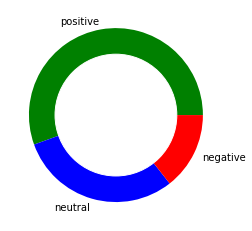

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tweet_list_df,"sentiment")
# names= pc.index
# size=pc["Percentage"]

names= pichart.index
size=pichart["Percentage"]

# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

#### Word Clouds

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
 a1_inputs
 a2_preprocessing_function.py
 cloud.png
'Colab Notebooks'
 dataset
'Discussion #5 Forecasting Numeric Data –Regression Methods.pdf'
'Forecasting Numeric Data- Regression Methods.pdf'
'Resume Niraj (1).pdf'
'Resume Niraj (2).pdf'
'Resume Niraj (3).pdf'
'Resume Niraj.pdf'
'Screen Shot 2021-10-11 at 4.38.19 PM.png'
'Untitled document.gdoc'


In [ ]:
#Function to Create Wordcloud

def create_wordcloud(text):
    mask = np.array(Image.open("./cloud.png"))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white",
                  mask = mask,
                  max_words=100,
                  stopwords=stopwords,
                  repeat=True)
    wc.generate(str(text))
    wc.to_file("c1_wordcloud.png")
    print("Word Cloud Saved Successfully")
    path="c1_wordcloud.png"
    display(Image.open(path))

Word Cloud Saved Successfully


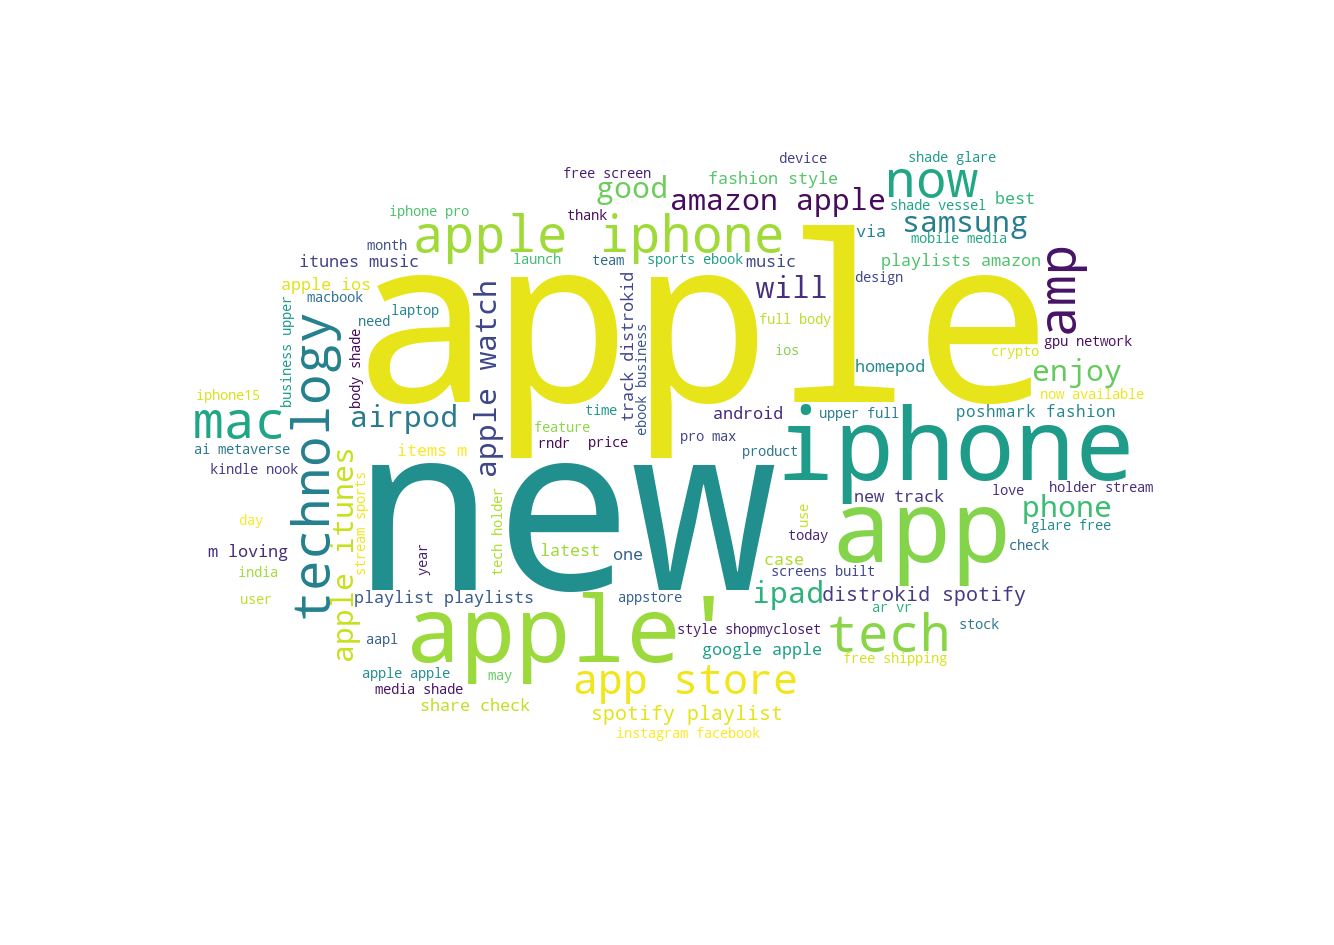

In [ ]:
# Creating wordcloud for all tweets

create_wordcloud(tweet_list_df["cleaned"].values)
# create_wordcloud(tweet_list_df_positive["text"].values)
# create_wordcloud(tweet_list_df_negative["cleaned"].values)
# create_wordcloud(tweet_list_df_neutral["text"].values)

#### Text Insights

In [ ]:
#Calculating tweet's lenght and word count
tweet_list_df['text_len'] = tweet_list_df['cleaned'].astype(str).apply(len)
tweet_list_df['text_word_count'] = tweet_list_df['cleaned'].apply(lambda x: len(str(x).split()))

In [ ]:
round(pd.DataFrame(tweet_list_df.groupby("sentiment").text_len.mean()),2)

,text_len
sentiment,
negative,149.74
neutral,118.69
positive,159.24


In [ ]:
round(pd.DataFrame(tweet_list_df.groupby("sentiment").text_word_count.mean()),2)

,text_word_count
sentiment,
negative,23.94
neutral,18.01
positive,24.81


From the analysis it is clear that the negative words are more than the postive and neutral words.

### Saving Output Tweets File to Drive

In [ ]:
tweet_list_df.to_csv("./c2_sentimentanalysis_output.csv", sep=',', encoding='UTF-8')
tweet_list_df.head(5)

,text,cleaned,polarity,subjectivity,sentiment,neg,neu,pos,compound,text_len,text_word_count
0,Why is it so difficult to make a choice? 🥧🍎🎃\n...,why is it so difficult to make choice pie appl...,-0.50000,1.000000,negative,0.228,0.772,0.000,-0.5009,66,12
1,📣 Our newsdesk will be open until 5pm today (1...,our newsdesk will be open until 5pm today 12p...,0.00000,0.500000,neutral,0.000,1.000,0.000,0.0000,231,34
2,$IBGR TeamD – The Next Evolution of Teamwear h...,ibgr teamd the next evolution of teamwear pel...,0.00000,0.000000,neutral,0.000,1.000,0.000,0.0000,199,29
3,"@sumek Yes, I mean.. Market rules apply to eve...",yes mean market rules apply to everyone regar...,0.09375,0.593750,positive,0.000,0.742,0.258,0.8687,237,39
4,I bought my first #apple product ever...\n🫣😑😕,i bought my first apple product ever,0.25000,0.333333,neutral,0.000,1.000,0.000,0.0000,37,7
